In [72]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import random
from scipy.ndimage import rotate as rtim
import albumentations as A

In [2]:
def read_img(img_path):
    return cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

def display_image(image, title="Image"):
    """
    Display an image using matplotlib. Rembember to use plt.show() to display the image
    """
    plt.imshow(image)
    plt.title(title)
    plt.show()


test xử lý các dạng nhiễu để thử tách nhiễu -> không thấy hiệu quả
nên gray scale ko nhỉ...

In [3]:
img_gt = "wb_localization_dataset/images/train/nlvnpf-0137-01-001.jpg"   #path to the groundtruth image
img = read_img(img_gt)

test xử lý sinh thêm ảnh

In [4]:
# Save an image
def save_image(image, output_path = "generated_dataset/images"):
    cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

In [101]:
#Phóng to thu nhỏ
def scale_labels(labels):
    x, y, w, h = map(float, labels)
    scaled_x = x
    scaled_y = y
    scaled_w = w
    scaled_h = h
    scaled_labels = [scaled_x, scaled_y, scaled_w, scaled_h]
    return scaled_labels

def scale_image(image, scale_x, scale_y, interpolation=cv2.INTER_CUBIC):
    width = int(image.shape[1] * scale_x)
    height = int(image.shape[0] * scale_y)
    scaled_image = cv2.resize(image, (width, height), interpolation=interpolation)
    return scaled_image

def handle_scale_labels_file(in_file, out_file):
    with open(out_file, "w") as out:
        pass
    with open(in_file, "r") as f, open(out_file, "w") as out:
        for line in f.readlines():
            coord = list(map(float, line.strip().split()))
            coord[0] = int(coord[0])
            out.write(f"{coord[0]} {coord[1]:.6f} {coord[2]:.6f} {coord[3]:.6f} {coord[4]:.6f}\n")


sinh dataset sau scale 

In [104]:
def handle_scale_convert(images_folder, labels_folder):
    out_folder = "generated_dataset/"
    out_images = out_folder + "images/val/"
    out_labels = out_folder + "labels/val/"

    for filename in os.listdir(images_folder):
        if filename.endswith(".jpg"):
            scale_x = round(random.uniform(0.5, 2), 1)
            scale_y = round(random.uniform(0.5, 2), 1)   
            image_file = os.path.join(images_folder, filename)
            out_img_name = out_images + "__scale__" + filename
            image = read_img(image_file)
            scaled_image = scale_image(image, scale_x, scale_y)
            save_image(scaled_image, out_img_name)


    for filename in os.listdir(labels_folder):
        if filename.endswith(".txt"):
            label_file = os.path.join(labels_folder, filename)
            out_label_name = out_labels + "__scale__" + filename
            handle_scale_labels_file(label_file, out_label_name)

handle_scale_convert("wb_localization_dataset/images/val", "wb_localization_dataset/labels/val")

sinh dataset xoay ảnh

In [47]:
with open("generated_dataset/labels/test_rotate1.txt", "r") as f, open("labels_new/train/test.txt", "w") as out:
    for line in f:
        label, x_center, y_center, width, height = line.strip().split()
        x_center, y_center, width, height = map(float, [x_center, y_center, width, height])

        # Convert coordinates
        x_upper_left = x_center - (width / 2)
        y_upper_left = y_center - (height / 2)
        x_lower_right = x_center + (width / 2)
        y_lower_right = y_center + (height / 2)

        # Write the new coordinates to the output file
        out.write(f"{label} {x_upper_left:.6f} {y_upper_left:.6f} {x_lower_right:.6f} {y_lower_right:.6f}\n")

In [63]:
def rotate_around_point(origin, point, angle):
    radians = math.radians(angle)
    x, y = point
    ox, oy = origin

    dx = x - ox
    dy = y - oy

    rotated_x = ox + dx * math.cos(radians) - dy * math.sin(radians)
    rotated_y = oy + dx * math.sin(radians) + dy * math.cos(radians)

    return rotated_x, rotated_y



def rotate_labels(labels, angle, img_w, img_h, ratio):
    x, y, w, h= labels
    ox = (img_w / 2) * ratio
    oy = (img_h / 2) * ratio
   

    xn, yn = x * img_w * ratio, y * img_h * ratio
    xp, yp = rotate_around_point((ox, oy), (xn, yn), angle)

   
    rotated_x = xp / (img_w * ratio)
    rotated_y = yp / (img_w * ratio)
    rotated_labels = [rotated_x, rotated_y, w, h]
    return rotated_labels

def rotate_image(image, angle):
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height), flags=cv2.INTER_LINEAR)
    return rotated_image

def expand_rotate_image(image, angle):
    return rtim(image, angle)


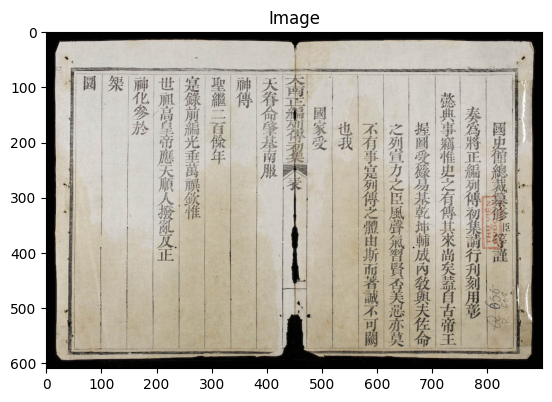

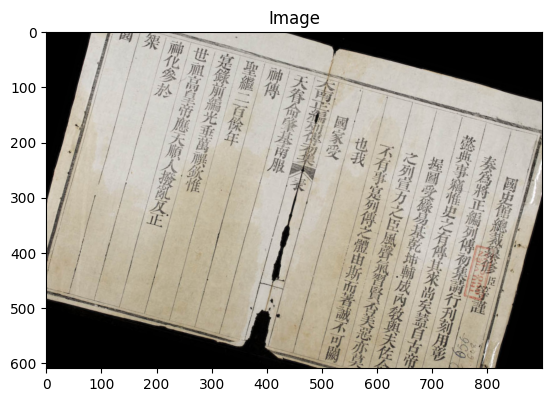

1.0


In [68]:
angle = 15

rotated_img = rotate_image(img, -angle)
display_image(img)
display_image(rotated_img)
save_image(rotated_img, "generated_dataset/images/test_rotate1.jpg")
ratio = rotated_img.shape[0] / img.shape[0]
print(ratio)

label_file = "wb_localization_dataset/labels/train/nlvnpf-0137-01-001.txt"
label_file_out = "generated_dataset/labels/test_rotate1.txt"
with open(label_file_out, "w") as out:
    pass
with open(label_file, "r") as f, open(label_file_out, "w") as out:
    for line in f.readlines():
        cut_line = list(map(float, line.strip().split()[1:]))
        rotated_line = rotate_labels(cut_line, angle, img.shape[0], img.shape[1], ratio)
        out.write(f"{line[0]} {rotated_line[0]:.6f} {rotated_line[1]:.6f} {rotated_line[2]:.6f} {rotated_line[3]:.6f}\n")
        

with open("generated_dataset/labels/test_rotate1.txt", "r") as f, open("labels_new/train/test.txt", "w") as out:
    for line in f:
        label, x_center, y_center, width, height = line.strip().split()
        x_center, y_center, width, height = map(float, [x_center, y_center, width, height])

        # Convert coordinates
        x_upper_left = x_center - (width / 2)
        y_upper_left = y_center - (height / 2)
        x_lower_right = x_center + (width / 2)
        y_lower_right = y_center + (height / 2)

        # Write the new coordinates to the output file
        out.write(f"{label} {x_upper_left:.6f} {y_upper_left:.6f} {x_lower_right:.6f} {y_lower_right:.6f}\n")

mệt quá, albumenatations vậy TvT

In [258]:
# PLOT BB TO DEBUG
def plot_BB(image_path, coord_path):
    image = read_img(image_path)

    with open(coord_path, "r") as f:
        coordinates = [line.strip().split()[1:] for line in f.readlines()]

    plt.imshow(image)
    for coord in coordinates:
        # Split the coordinates
        x_upper_left, y_upper_left, x_below_right, y_below_right = map(float, coord)
        x = x_upper_left
        y = y_upper_left
        w = x_below_right - x_upper_left
        h = y_below_right - y_upper_left
        # Scale the coordinates to the image dimensions
        x *= image.shape[1]
        y *= image.shape[0]
        w *= image.shape[1]
        h *= image.shape[0]
        # Convert coordinates to integers
        x, y, w, h = map(int, (x, y, w, h))

        rect_box = plt.Rectangle((x, y), w, h, color='red', fill=False, lw=1)
        plt.gca().add_patch(rect_box)

    plt.show()

In [317]:
def multi_transform(image, bboxes):
    # Định nghĩa phép biến đổi bounding box
    bbox_params = A.BboxParams(format='pascal_voc', min_area=0, min_visibility=0, label_fields=['category'])
    transform = A.Compose([
        A.RandomBrightnessContrast(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Blur(blur_limit=3, p=0.5),
        A.GaussNoise(p = 1.0),
        A.Rotate(limit=30, p=0.5, expand=True),
        A.MultiplicativeNoise(multiplier=[0.5, 1.5], per_channel=True, elementwise=True, p=0.5),
    ], bbox_params=bbox_params)
    
    # Áp dụng phép biến đổi
    transformed = transform(image=image, bboxes=bboxes, category=[0]*len(bboxes))

    # Sau khi augmentation
    transformed_img = transformed['image']
    transformed_bboxes = transformed['bboxes']
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(transformed_img)
    axes[1].set_title('Augmented Image')
    axes[1].axis('off')
    plt.show()
    return transformed_img, transformed_bboxes

In [337]:
inf_name = "labels_new/train/nlvnpf-0137-01-001.txt"
outf_name = "generated_dataset/labels/test1.txt"
outf_img = "generated_dataset/images/test1.jpg"

with open(inf_name, "r") as inf, open(outf_name, "w") as outf:
    bboxes = []
    i = 0
    for line in inf.readlines():
        bbox = list(map(float, line.strip().split()[1:]))
        # bbox[0] *= img.shape[0]
        # bbox[1] *= img.shape[1]
        # bbox[2] *= img.shape[0]
        # bbox[3] *= img.shape[1]
        # bbox = list(map(int, bbox))
        bboxes.append(bbox)

    print(bboxes)
    agm_img, agm_bbox = multi_transform(img, bboxes)
    print(agm_bbox)
    for bbox in agm_bbox:
        outf.write(f"{'0'} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")
    
    display_image(agm_img)
    save_image(agm_img, outf_img)
    

[[546, 281, 567, 317], [292, 113, 319, 146], [419, 278, 440, 315], [451, 540, 473, 579], [200, 163, 222, 206], [200, 120, 222, 163], [231, 120, 254, 162], [451, 579, 473, 618], [483, 578, 504, 616], [451, 653, 473, 691], [231, 162, 255, 208], [451, 464, 474, 504], [451, 237, 473, 280], [450, 427, 474, 464], [482, 466, 504, 504], [73, 116, 97, 163], [452, 504, 473, 541], [199, 277, 222, 317], [389, 503, 410, 544], [482, 159, 505, 206], [136, 162, 159, 202], [136, 315, 159, 357], [168, 163, 191, 203], [105, 119, 128, 163], [513, 354, 536, 393], [103, 239, 128, 281], [388, 576, 410, 619], [482, 281, 504, 320], [420, 503, 441, 542], [388, 426, 410, 467], [262, 160, 286, 202], [136, 119, 159, 162], [482, 320, 504, 355], [451, 691, 473, 730], [483, 541, 504, 578], [483, 355, 504, 392], [263, 120, 286, 162], [387, 278, 409, 317], [420, 542, 441, 582], [420, 615, 441, 658], [388, 690, 410, 730], [513, 427, 535, 469], [452, 618, 472, 653], [136, 277, 158, 315], [482, 241, 504, 281], [420, 466, 

ValueError: Expected y_max for bbox (0.5011111111111111, 0.9491803278688524, 0.5255555555555556, 1.0131147540983607, 0) to be in the range [0.0, 1.0], got 1.0131147540983607.

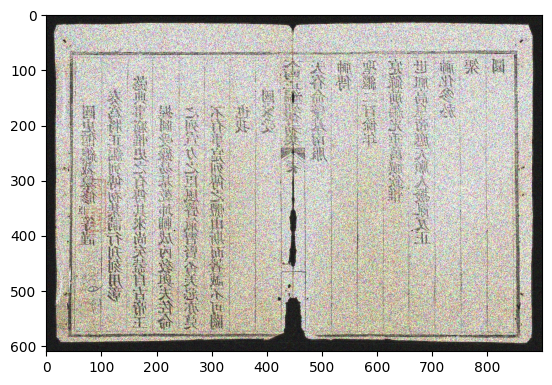

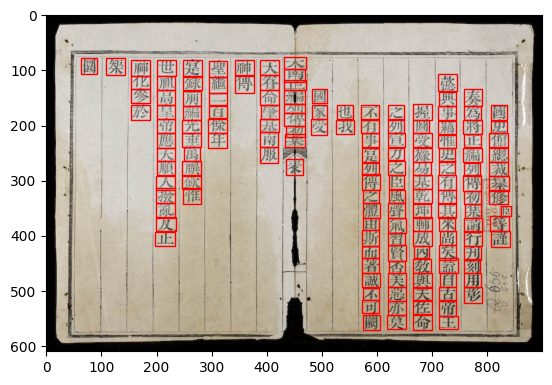

In [334]:
img_dir = "generated_dataset/images/test1.jpg"
coord_dir = "generated_dataset/labels/test1.txt"
plot_BB(img_dir, coord_dir)


img_dir2 = "wb_localization_dataset/images/train/nlvnpf-0137-01-001.jpg"
coord_dir2 = "labels_new/train/nlvnpf-0137-01-001.txt"
plot_BB(img_dir2, coord_dir2)